In [1]:
import os
import pandas as pd
import numpy as np
import pickle

In [9]:
with open('dataframe_clean.pkl', 'rb') as f:
    df = pickle.load(f)

In [3]:
df = df.drop(columns='Sample_Weights')
df

Good_Health Health_Insurance Hypertension High_Cholesterol  \
0              2.0              1.0          1.0              1.0   
1              1.0              2.0          2.0              2.0   
3              2.0              1.0          1.0              1.0   
4              2.0              1.0          2.0              2.0   
5              1.0              9.0          1.0              2.0   
...            ...              ...          ...              ...   
441451         2.0              9.0          1.0              1.0   
441452         1.0              1.0          2.0              2.0   
441453         2.0              9.0          1.0              1.0   
441454         1.0              1.0          1.0              2.0   
441455         1.0              1.0          1.0              1.0   

       Asthma_Status Arthritis Race Age_Cat BMI_Cat Education_Level  ...  \
0                1.0       1.0  1.0     5.0     4.0             2.0  ...   
1                3.0       2.0  1.0     4.0     3.0             4.0  ...   
3                3.0       1.0  1.0     5.0     3.0             2.0  ...   
4                3.0       1.0  1.0     5.0     2.0             3.0  ...   
5                3.0       1.0  1.0     6.0     3.0             1.0  ...   
...              ...       ...  ...     ...     ...             ...  ...   
441451           3.0       1.0  5.0     6.0     1.0             1.0  ...   
441452           3.0       2.0  5.0     2.0     3.0             3.0  ...   
441453           3.0       2.0  5.0     6.0     4.0             2.0  ...   
441454           3.0       2.0  5.0     4.0     2.0             3.0  ...   
441455           3.0       2.0  5.0     5.0     2.0             4.0  ...   

       Pneumonia_Vaccine    HIV Bronchitis Depression Kidney_Disease Diabetes  \
0                   65.0    1.0        1.0        1.0            2.0      2.0   
1                   65.0    2.0        2.0        2.0            2.0      2.0   
3                   65.0    9.0        2.0        1.0            2.0      2.0   
4                   65.0    1.0        2.0        2.0            2.0      2.0   
5                    1.0    2.0        2.0        2.0            2.0      2.0   
...                  ...    ...        ...        ...            ...      ...   
441451               2.0    2.0        2.0        2.0            2.0      1.0   
441452              65.0    1.0        2.0        2.0            2.0      2.0   
441453               9.0  999.0        2.0        2.0            2.0      2.0   
441454              65.0    2.0        2.0        2.0            2.0      2.0   
441455              65.0    1.0        1.0        2.0            2.0      1.0   

        SEX Marital_Status Sodium Heart_Disease  
0       2.0            1.0  999.0           0.0  
1       2.0            2.0    2.0           0.0  
3       2.0            1.0    2.0           0.0  
4       2.0            1.0    2.0           0.0  
5       2.0            3.0    2.0           0.0  
...     ...            ...    ...           ...  
441451  2.0            3.0    1.0           0.0  
441452  2.0            1.0    2.0           0.0  
441453  2.0            1.0  999.0           0.0  
441454  1.0            5.0    1.0           0.0  
441455  2.0            1.0    1.0           1.0  

[437514 rows x 26 columns]

In [4]:
df.columns

Index(['Good_Health', 'Health_Insurance', 'Hypertension', 'High_Cholesterol',
       'Asthma_Status', 'Arthritis', 'Race', 'Age_Cat', 'BMI_Cat',
       'Education_Level', 'Income_Level', 'Smoker_Status', 'Heavy_Drinker',
       'Physical_Activity', 'Seatbelt', 'Flu_Shot', 'Pneumonia_Vaccine', 'HIV',
       'Bronchitis', 'Depression', 'Kidney_Disease', 'Diabetes', 'SEX',
       'Marital_Status', 'Sodium', 'Heart_Disease'],
      dtype='object')

In [10]:
from pgmpy.models.BayesianNetwork import BayesianNetwork
from pgmpy.estimators import StructureEstimator, BayesianEstimator, HillClimbSearch, PC
from sklearn.preprocessing import LabelEncoder

class BayesianModel(BayesianNetwork):

    def __init__(self, *, 
        ebunch=None, 
        graph_search_algo=HillClimbSearch, 
        scoring_method='k2score', 
        start_dag=None, 
        fixed_edges=set(), 
        tabu_length=100, 
        max_indegree=None, 
        black_list=None, 
        white_list=None, 
        epsilon=0.0001, 
        max_iter=1000000.0, 
        show_progress=True, 

        variant='stable',
        ci_test='chi_square',
        max_cond_vars=5,
        return_type='dag',
        significance_level=0.01,

        estimator=BayesianEstimator, 
        prior_type='BDeu', 
        pseudo_counts=[], 
        equivalent_sample_size=5
        ):
        
        super().__init__(ebunch)
        
        self.ebunch = ebunch
        self.graph_search_algo = graph_search_algo
        self.scoring_method = scoring_method
        self.start_dag = start_dag
        self.fixed_edges = fixed_edges
        self.tabu_length = tabu_length
        self.max_indegree = max_indegree
        self.black_list = black_list
        self.white_list = white_list
        self.epsilon = epsilon
        self.max_iter = max_iter
        self.show_progress = show_progress

        self.variant = variant
        self.ci_test = ci_test
        self.max_cond_vars = max_cond_vars
        self.return_type = return_type
        self.significance_level = significance_level

        self.estimator = estimator
        self.prior_type = prior_type
        self.pseudo_counts = pseudo_counts
        self.equivalent_sample_size = equivalent_sample_size

    def fit(self, X_train, y_train, **fit_params):

        data = pd.concat([X_train, y_train], axis=1)
        graph_search_est = self.graph_search_algo(data)
        if self.graph_search_algo == HillClimbSearch:
            parameters = dict(
                scoring_method=self.scoring_method,
                start_dag=self.start_dag,
                fixed_edges=self.fixed_edges,
                tabu_length=self.tabu_length,
                max_indegree=self.max_indegree,
                black_list=self.black_list,
                white_list=self.white_list,
                epsilon=self.epsilon,
                max_iter=self.max_iter,
                show_progress=self.show_progress
            )
        elif self.graph_search_algo == PC:
            parameters = dict(
                variant=self.variant,
                ci_test=self.ci_test,
                max_cond_vars=self.max_cond_vars,
                return_type=self.return_type,
                significance_level=self.significance_level,
                show_progress=self.show_progress
            )
        dag = graph_search_est.estimate(**parameters)

        extra_columns = list(set(data.columns) - set(dag.nodes))
        if y_train.name in extra_columns:
            raise ValueError('Resulting DAG does not contain target. It cannot be used to make predictions.')
        if len(extra_columns) > 0:
            data = data.drop(columns=extra_columns)
        elif len(extra_columns) < 0:
            raise ValueError('Invalid value for extra_columns')
        
        super().__init__(dag)
        self.ebunch = list(dag.nodes)
        print('Now fitting the graph...')
        super().fit(
            data, 
            estimator=self.estimator, 
            prior_type=self.prior_type, 
            pseudo_counts=self.pseudo_counts,
            equivalent_sample_size=self.equivalent_sample_size,
            **fit_params
        )
        print('Succesfully fitted the graph')

        self.X_ = X_train
        self.y_ = y_train
        self.fit_params_ = fit_params
        self.classes_ = LabelEncoder().fit(y_train).classes_

        return self

    def predict(self, X, stochastic=False, n_jobs=-1):
        extra_columns = list(set(X.columns) - set(self.nodes))
        if len(extra_columns) > 0:
            X = X.drop(columns=extra_columns)
        elif len(extra_columns) < 0:
            raise ValueError('Invalid value for extra_columns')
        y_pred_df = super().predict(X, stochastic, n_jobs)
        y_pred = y_pred_df.to_numpy()
        self.y_pred_ = y_pred

        return y_pred

    def predict_proba(self, X):
        extra_columns = list(set(X.columns) - set(self.nodes))
        if len(extra_columns) > 0:
            X = X.drop(columns=extra_columns)
        elif len(extra_columns) < 0:
            raise ValueError('Invalid value for extra_columns')
        y_pred_proba_df = super().predict_probability(X)
        y_pred_proba = y_pred_proba_df.to_numpy()
        self.y_pred_proba_ = y_pred_proba
        
        return y_pred_proba
    
    def get_params(self, deep=True):
        return {
            'ebunch':self.ebunch,
            'graph_search_algo':self.graph_search_algo,
            'scoring_method':self.scoring_method,
            'start_dag':self.start_dag,
            'fixed_edges':self.fixed_edges,
            'tabu_length':self.tabu_length,
            'max_indegree':self.max_indegree,
            'black_list':self.black_list,
            'white_list':self.white_list,
            'epsilon':self.epsilon,
            'max_iter':self.max_iter,
            'show_progress':self.show_progress,
            'estimator':self.estimator,
            'prior_type':self.prior_type,
            'pseudo_counts':self.pseudo_counts,
            'equivalent_sample_size':self.equivalent_sample_size
        }
    
    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

In [11]:
from imblearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate

def cv_scorer(ml_algo, scoring, *data, model_name=None, algo_params={}, resampler=None, output=True):    
    if len(data) == 2:
        X, y = tuple(data)
        w = None
    elif len(data) == 3:
        X, y, w = tuple(data)
    else:
        print('Invalid length for "data".')
        return
    
    if resampler != None:
        model = Pipeline([('Resampling', resampler()), (model_name, ml_algo(**algo_params))])
    else:
        model = Pipeline([(model_name, ml_algo(**algo_params))])
    
    cv_scores = cross_validate(model, X, y, scoring=scoring, fit_params={}, return_estimator=True)
    if output == True:
        if type(model_name) != type(None):
            print(model_name + ' cv_scores:')
        else:
            print('cv_scores:')
        print(cv_scores)
        print()
    
    cv_scores_summary = {}
    cv_scores_summary['estimator'] = cv_scores['estimator']
    for score in scoring:
        scores_ = cv_scores['test_' + score]
        mean_ = cv_scores['test_' + score].mean()
        std_ = cv_scores['test_' + score].std()
        
        cv_scores_summary[score]= dict(zip(['scores', 'mean', 'std'], [scores_, mean_, std_]))
        
        if output == True:
            print(score + ' mean: ' + f'{mean_:0.2f}')
            print(score + ' std: ' + f'{std_:0.4f}')
            print()
    if print == True:
        print()
    
    if type(model_name) != type(None):
        return {model_name:cv_scores_summary}, cv_scores
    else:
        return cv_scores_summary, cv_scores

In [12]:
included_columns = ['Good_Health', 'Hypertension', 'High_Cholesterol', 'Smoker_Status', 'Age_Cat', 'Diabetes', 'Sodium', 'Heavy_Drinker', 'Heart_Disease', 'SEX', 'Sample_Weights']
df = df[included_columns]
df

Good_Health Hypertension High_Cholesterol Smoker_Status Age_Cat  \
0              2.0          1.0              1.0           3.0     5.0   
1              1.0          2.0              2.0           1.0     4.0   
3              2.0          1.0              1.0           4.0     5.0   
4              2.0          2.0              2.0           4.0     5.0   
5              1.0          1.0              2.0           4.0     6.0   
...            ...          ...              ...           ...     ...   
441451         2.0          1.0              1.0           4.0     6.0   
441452         1.0          2.0              2.0           4.0     2.0   
441453         2.0          1.0              1.0           3.0     6.0   
441454         1.0          1.0              2.0           4.0     4.0   
441455         1.0          1.0              1.0           4.0     5.0   

       Diabetes Sodium Heavy_Drinker Heart_Disease  SEX  Sample_Weights  
0           2.0  999.0           2.0           0.0  2.0      341.384853  
1           2.0    2.0           2.0           0.0  2.0      108.060903  
3           2.0    2.0           2.0           0.0  2.0      341.384853  
4           2.0    2.0           2.0           0.0  2.0      258.682223  
5           2.0    2.0           2.0           0.0  2.0      256.518591  
...         ...    ...           ...           ...  ...             ...  
441451      1.0    1.0           2.0           0.0  2.0      531.980410  
441452      2.0    2.0           2.0           0.0  2.0      746.416599  
441453      2.0  999.0           2.0           0.0  2.0      207.663634  
441454      2.0    1.0           2.0           0.0  1.0      515.758894  
441455      1.0    1.0           2.0           1.0  2.0      224.379062  

[437514 rows x 11 columns]

In [13]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=['Heart_Disease', 'Sample_Weights'])
y = df['Heart_Disease']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=42)

X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)

y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

In [59]:
def no_parents_black_list(list_orig, list_no_parents):
    '''Given a list of nodes, list_orig, and another list of nodes that should not have parents, 
    list_no_parents, generates the required black_list for use in graph search algorithms'''

    list_start = []
    list_end = []
    for node_no_parent in list_no_parents:
        list_temp_1 = list_orig.copy()
        list_temp_1.remove(node_no_parent)
        list_temp_2 = [node_no_parent] * len(list_temp_1)
        list_start.append(list_temp_1)
        list_end.append(list_temp_2)
    assert len(list_start) == len(list_end)
    
    black_list = []
    for i in range(len(list_start)):
        black_list = black_list + list(zip(list_start[i], list_end[i]))

    return black_list



In [61]:
black_list = no_parents_black_list(list(pd.concat([X, y], axis=1).columns), ['SEX', 'Age_Cat'])
black_list

bm = BayesianModel(graph_search_algo=HillClimbSearch, estimator=BayesianEstimator, prior_type='BDeu', equivalent_sample_size=5, black_list=black_list)                   
bm.fit(X_train, y_train)
y_pred = bm.predict(X_test)
y_pred_proba = bm.predict_proba(X_test)

[('Good_Health', 'SEX'),
 ('Hypertension', 'SEX'),
 ('High_Cholesterol', 'SEX'),
 ('Smoker_Status', 'SEX'),
 ('Age_Cat', 'SEX'),
 ('Diabetes', 'SEX'),
 ('Sodium', 'SEX'),
 ('Heavy_Drinker', 'SEX'),
 ('Heart_Disease', 'SEX'),
 ('Good_Health', 'Age_Cat'),
 ('Hypertension', 'Age_Cat'),
 ('High_Cholesterol', 'Age_Cat'),
 ('Smoker_Status', 'Age_Cat'),
 ('Diabetes', 'Age_Cat'),
 ('Sodium', 'Age_Cat'),
 ('Heavy_Drinker', 'Age_Cat'),
 ('SEX', 'Age_Cat'),
 ('Heart_Disease', 'Age_Cat')]

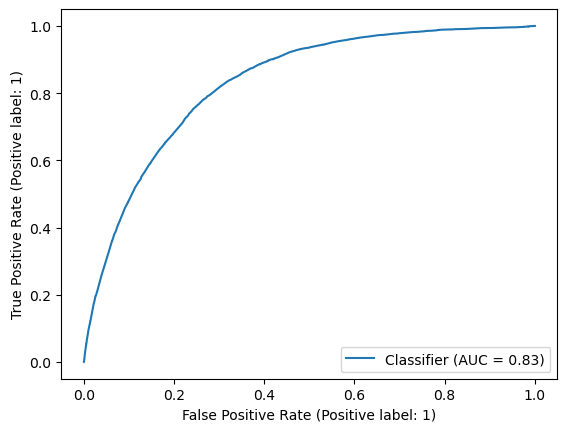

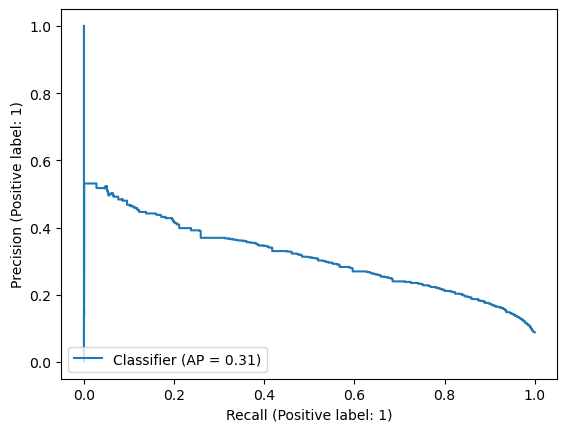

In [63]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay

RocCurveDisplay.from_predictions(y_test, y_pred_proba[:, 1])
plt.show()
PrecisionRecallDisplay.from_predictions(y_test, y_pred_proba[:, 1])
plt.show()

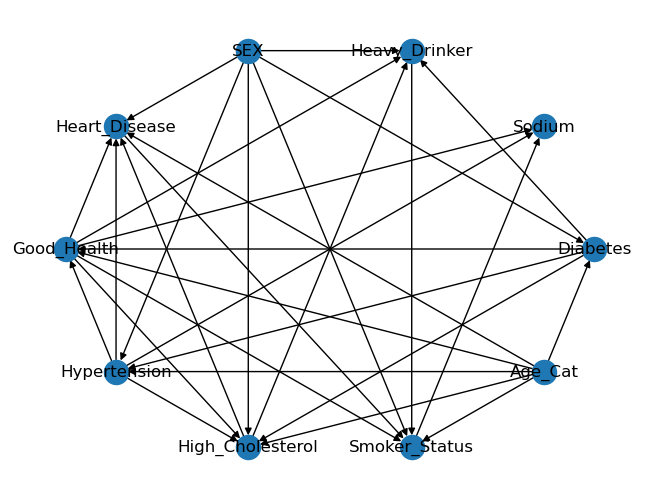

In [64]:
import networkx as nx

nx.draw_shell(bm, with_labels=True)

In [7]:
from sklearn.model_selection import train_test_split

X = df.drop(columns='Heart_Disease')
y = df['Heart_Disease']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=42)

X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)

y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

In [8]:
path = './y_predictions.pkl'
if os.path.exists(path):
    with open(path, 'rb') as f:
        _ = pickle.load(f)
        y_test = pickle.load(f)
        y_pred = pickle.load(f)
        y_proba = pickle.load(f)
        print(f'Loaded from {path}.')
else:
    from pgmpy.estimators import BayesianEstimator

    bm = BayesianModel(graph_search_algo=HillClimbSearch, graph_search_params={}, estimator=BayesianEstimator, prior_type='BDeu', equivalent_sample_size=5)
    bm.fit(X_train, y_train)
    y_pred = bm.predict(X_test)
    y_proba = bm.predict_proba(X_test)
    with open(path, 'wb') as f:
        pickle.dump(3, f)
        pickle.dump(y_test, f)
        pickle.dump(y_pred, f)
        pickle.dump(y_proba, f)
    print('Model trained.')

Loaded from ./y_predictions.pkl.


In [9]:
X_sample = X_test.astype(float)
y_sample = y_test.astype(float)

In [10]:
X_sample_train, X_sample_test, y_sample_train, y_sample_test = train_test_split(X_sample, y_sample, test_size=0.10, stratify=y_sample, random_state=42)

In [11]:
X_sample_train.shape, y_sample_train.shape, X_sample_test.shape, y_sample_test.shape

((78752, 25), (78752,), (8751, 25), (8751,))

In [16]:
bm = BayesianModel(graph_search_algo=HillClimbSearch, estimator=BayesianEstimator, prior_type='BDeu', equivalent_sample_size=5)
bm.fit(X_sample_train, y_sample_train)

  0%|          | 0/5 [00:00<?, ?it/s]

/home/hiram_g_menendez/Springboard/.conda/lib/python3.10/site-packages/pgmpy/estimators/CITests.py:548: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for z_state, df in data.groupby(Z):
/home/hiram_g_menendez/Springboard/.conda/lib/python3.10/site-packages/pgmpy/estimators/CITests.py:548: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for z_state, df in data.groupby(Z):
/home/hiram_g_menendez/Springboard/.conda/lib/python3.10/site-packages/pgmpy/estimators/CITests.py:548: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list 

KeyboardInterrupt: 

In [13]:
y_sample_pred = bm.predict(X_sample_test)
y_sample_proba = bm.predict_proba(X_sample_test)

  0%|          | 0/7236 [00:00<?, ?it/s]

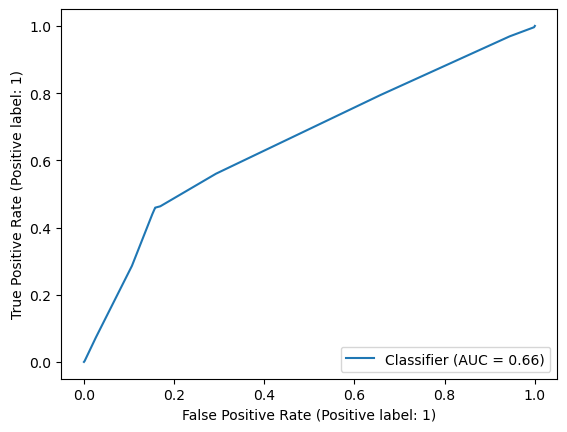

In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_predictions(y_sample_test, y_sample_proba[:, 1])
plt.show()

In [ ]:
y_sample_proba.to_numpy()

In [ ]:
from pgmpy.estimators import BayesianEstimator
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.model_selection import StratifiedKFold

roc_auc_scorer = make_scorer(roc_auc_score, needs_proba=True)

scores = cross_validate(BayesianModel(graph_search_algo=HillClimbSearch, estimator=BayesianEstimator, prior_type='BDeu', equivalent_sample_size=5), 
    X_sample, y_sample, scoring=['recall', 'roc_auc'], cv=StratifiedKFold())
scores

In [ ]:
cv_scores_summary, cv_scores = cv_scorer(BayesianModel, ['recall'], X_sample, y_sample, model_name='BayesianModel', algo_params=dict(graph_search_algo=HillClimbSearch, \
    graph_search_params={}, estimator=BayesianEstimator, prior_type='BDeu', equivalent_sample_size=5), resampler=None, output=True)

In [ ]:
from pgmpy.models.BayesianNetwork import BayesianNetwork

path = 'best_model.bif'
path_exists = os.path.exists(path)

if not path_exists:
    from pgmpy.estimators import HillClimbSearch, BayesianEstimator
    
    data_train = pd.concat([X_train, y_train], axis=1)
    est = HillClimbSearch(data_train)
    best_model = BayesianNetwork(est.estimate())
    best_model.fit(data_train, estimator=BayesianEstimator, prior_type='BDeu', equivalent_sample_size=5)
    del(data_train)
    best_model.save('best_model.bif', filetype='bif')
    print('Best model trained.')
else:
    
    best_model = BayesianNetwork.load('best_model.bif', filetype='bif')
    print('Best model loaded.')

In [ ]:
import networkx as nx

nx.draw_kamada_kawai(bm, with_labels=True)

In [ ]:
path = 'y_predictions.pkl'
path_exists = os.path.exists(path)

if not path_exists:
    y_pred = best_model.predict(X_test)
    y_pred_proba = best_model.predict_probability(X_test)

    with open(path, 'wb') as f:
        pickle.dump(2, f)
        pickle.dump(y_pred, f)
        pickle.dump(y_pred_proba, f)

else:
    with open(path, 'rb') as f:
        _ = pickle.load(f)
        y_pred = pickle.load(f)
        y_pred_proba = pickle.load(f)

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize='true')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_predictions(y_test, y_pred_proba.iloc[:, 1])
plt.show()

In [ ]:
from sklearn.metrics import roc_curve

def find_threshold(fpr_chosen):
    fpr, _, thresholds= roc_curve(y_test, y_pred_proba.iloc[:, 1])
    indices = np.where(fpr <= fpr_chosen)[0]
    index = indices[-1:-2:-1][0] + 1
    return thresholds[index]

def predict_with_treshold(proba, threshold):
    return (proba >= threshold).astype(float)

In [ ]:
y_pred_2 = predict_with_treshold(y_pred_proba.iloc[:, 1], find_threshold(0.2))

In [ ]:
y_pred_2.value_counts()

In [ ]:
print(classification_report(y_test, y_pred_2))

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_2, normalize='true')
plt.show()

In [ ]:
print('Node', 'Parents', 'InDegree')
for node in best_model.nodes:
    parents = best_model.get_parents(node)
    print(node, parents, len(parents))

In [ ]:
from pgmpy.inference.CausalInference import CausalInference

inference = CausalInference(best_model)

In [ ]:
phi = inference.query(['Heart_Disease'], do={'Hypertension':2.0})

In [ ]:
print(phi)

In [ ]:
inference.estimate_ate('Hypertension', 'Heart_Disease', data_train)

**Testing Active Trail Function**

In [ ]:
toy_model = BayesianNetwork([('Difficulty', 'Grade'), ('Intelligence', 'Grade'),('Intelligence', 'SAT'), ('Grade', 'Letter')])

In [ ]:
toy_model.get_random_cpds(n_states = {'Difficulty':2, 'Intelligence':2, 'Grade':5, 'SAT':2, 'Letter':2}, inplace=True)

In [ ]:
help(BayesianNetwork)

In [ ]:
nx.draw_kamada_kawai(toy_model, with_labels=True)

In [ ]:
for node in toy_model.nodes:
    print(toy_model.active_trail_nodes(node, []))

In [ ]:
toy_model.nodes

In [ ]:
toy_model.states

In [ ]:
df_toy = pd.DataFrame(index=[0])

In [ ]:
df_toy

In [ ]:
toy_model.predict_probability(df_toy)

In [ ]:
toy_model.active_trail_nodes(['SAT'])

In [ ]:
from pgmpy.inference.CausalInference import CausalInference
inference = CausalInference(toy_model)

In [ ]:
for i in range(5):
    print('Grade:', i)
    print(inference.query(['Letter'], do={'Grade':i}), '\n')

In [ ]:
inference.get_all_backdoor_adjustment_sets('Intelligence', 'Letter')